# HackTheBay: predictive analysis 


## 1. Catboost

Catboost can deal with missing values, so we want to test its capabilities on the non-imputed dataset. Furthermore, the dataset doesn't need to be dummified or log-transformed.

In [1]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import sklearn
from datetime import date
from sklearn import metrics

In [2]:
# Import catboost package
import catboost

In [3]:
# Load dataset
df = pd.read_csv('data/dfnitro3V2.csv', index_col=0)
df.head()

,new_date,CloudCover,HUC12,Latitude,Longitude,Method,SampleDepth,SampleId,WindDirection,WindSpeed,...,sfc_air_narr,u_wind_narr,v_wind_narr,windspeed_narr,wdirection_narr,precip24_narr,precip48_narr,PH,SA,of_dist
0,2019-03-24 12:28:00,NaN,NaN,38.6336,-75.6177,NaN,0.5,1.0,NaN,NaN,...,15.950953,-0.871403,1.188705,2.768492,319.92773,0.000631,0.000631,NaN,0.1,114.490129
1,2019-03-24 12:46:00,NaN,NaN,38.6422,-75.6068,NaN,0.3,1.0,NaN,NaN,...,15.950953,-0.732618,0.899643,4.375051,311.97590,0.000631,0.000631,NaN,0.1,115.173610
2,2019-03-24 13:05:00,NaN,NaN,38.6013,-75.6563,NaN,0.5,1.0,NaN,NaN,...,15.950953,-0.871403,1.188705,2.768492,319.92773,0.000631,0.000631,NaN,0.1,111.960973
3,2019-03-24 15:20:00,NaN,NaN,38.5645,-75.6723,NaN,0.5,1.0,NaN,NaN,...,18.271510,-1.326357,4.009186,4.656967,345.99466,0.000631,0.008444,NaN,0.1,109.322587
4,2019-03-24 15:34:00,NaN,NaN,38.5583,-75.5696,NaN,0.5,1.0,NaN,NaN,...,18.271510,-1.326357,4.009186,4.656967,345.99466,0.000631,0.008444,NaN,0.1,109.851749


In [4]:
df.columns

Index(['new_date', 'CloudCover', 'HUC12', 'Latitude', 'Longitude', 'Method',
       'SampleDepth', 'SampleId', 'WindDirection', 'WindSpeed', 'HUC12_',
       'FIPS_', 'COUNTY_', 'STATE_', 'areaacres', 'za_mean', 'lc_11', 'lc_21',
       'lc_22', 'lc_23', 'lc_24', 'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52',
       'lc_71', 'lc_81', 'lc_82', 'lc_90', 'lc_95', 'month', 'year', 'week',
       'dayofweek', 'hour', 'min', 'quarter', 'DO', 'TN', 'TP', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr', 'PH', 'SA',
       'of_dist'],
      dtype='object')

In [12]:
df['new_date'] = pd.to_datetime(df.new_date)
df.new_date.max()

Timestamp('2020-04-02 12:00:00')

In [13]:
df['today'] = pd.to_datetime('2020-04-02 12:00:00')

In [15]:
df['date_delta'] = (df.today.subtract(df.new_date)).dt.total_seconds().astype(int)

In [16]:
#Remove columns not used for prediction:  
df.drop(['new_date', 'today', 'CloudCover', 'Latitude', 'Longitude', 'SampleDepth', 'HUC12', 'FIPS_', 'COUNTY_', 'STATE_', 'WindDirection', 
         'WindSpeed', 'Method', 'min', 'hour', 'SampleId', 'DO', 'TP', 'PH', 'SA'], inplace=True, axis =1)
df.head()

,HUC12_,areaacres,za_mean,lc_11,lc_21,lc_22,lc_23,lc_24,lc_31,lc_41,...,sfc_runoff,sfc_air_narr,u_wind_narr,v_wind_narr,windspeed_narr,wdirection_narr,precip24_narr,precip48_narr,of_dist,date_delta
0,20801090405,27423.32,67.259003,0.020593,0.079970,0.048282,0.021079,0.010965,0.000073,0.019644,...,0.0,15.950953,-0.871403,1.188705,2.768492,319.92773,0.000631,0.000631,114.490129,32398320
1,20801090404,24031.76,67.646972,0.010316,0.084094,0.057586,0.035233,0.010908,0.002193,0.022279,...,0.0,15.950953,-0.732618,0.899643,4.375051,311.97590,0.000631,0.000631,115.173610,32397240
2,20801090405,27423.32,67.259003,0.020593,0.079970,0.048282,0.021079,0.010965,0.000073,0.019644,...,0.0,15.950953,-0.871403,1.188705,2.768492,319.92773,0.000631,0.000631,111.960973,32396100
3,20801090205,15133.36,70.482388,0.021837,0.046304,0.012638,0.002175,0.001058,0.000059,0.029155,...,0.0,18.271510,-1.326357,4.009186,4.656967,345.99466,0.000631,0.008444,109.322587,32388000
4,20801090204,19226.56,67.477580,0.008295,0.085308,0.061372,0.032589,0.010817,0.000081,0.025266,...,0.0,18.271510,-1.326357,4.009186,4.656967,345.99466,0.000631,0.008444,109.851749,32387160


In [17]:
all_cols = df.columns
all_cols

Index(['HUC12_', 'areaacres', 'za_mean', 'lc_11', 'lc_21', 'lc_22', 'lc_23',
       'lc_24', 'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71', 'lc_81',
       'lc_82', 'lc_90', 'lc_95', 'month', 'year', 'week', 'dayofweek',
       'quarter', 'TN', 'airtemp_narr', 'precip3_narr', 'humidity_narr',
       'cl_cover_narr', 'sfc_runoff', 'sfc_air_narr', 'u_wind_narr',
       'v_wind_narr', 'windspeed_narr', 'wdirection_narr', 'precip24_narr',
       'precip48_narr', 'of_dist', 'date_delta'],
      dtype='object')

### Setup Catboost

In [18]:
X = df.drop('TN', axis=1)
y = df.TN

In [19]:
categorical = ['HUC12_', 'month', 'year', 'dayofweek', 'quarter', 'week']


In [20]:
numeric = all_cols[~all_cols.isin(categorical)]
numeric

Index(['areaacres', 'za_mean', 'lc_11', 'lc_21', 'lc_22', 'lc_23', 'lc_24',
       'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71', 'lc_81', 'lc_82',
       'lc_90', 'lc_95', 'TN', 'airtemp_narr', 'precip3_narr', 'humidity_narr',
       'cl_cover_narr', 'sfc_runoff', 'sfc_air_narr', 'u_wind_narr',
       'v_wind_narr', 'windspeed_narr', 'wdirection_narr', 'precip24_narr',
       'precip48_narr', 'of_dist', 'date_delta'],
      dtype='object')

In [21]:
#Change some numericals to categorical variables
X[categorical] = X[categorical].astype(str)

In [22]:
X.dtypes

HUC12_              object
areaacres          float64
za_mean            float64
lc_11              float64
lc_21              float64
lc_22              float64
lc_23              float64
lc_24              float64
lc_31              float64
lc_41              float64
lc_42              float64
lc_43              float64
lc_52              float64
lc_71              float64
lc_81              float64
lc_82              float64
lc_90              float64
lc_95              float64
month               object
year                object
week                object
dayofweek           object
quarter             object
airtemp_narr       float64
precip3_narr       float64
humidity_narr      float64
cl_cover_narr      float64
sfc_runoff         float64
sfc_air_narr       float64
u_wind_narr        float64
v_wind_narr        float64
windspeed_narr     float64
wdirection_narr    float64
precip24_narr      float64
precip48_narr      float64
of_dist            float64
date_delta           int32
d

Check for missing values

In [23]:
null_value_stats = df.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

za_mean    144
lc_11      144
lc_21      144
lc_22      144
lc_23      144
lc_24      144
lc_31      144
lc_41      144
lc_42      144
lc_43      144
lc_52      144
lc_71      144
lc_81      144
lc_82      144
lc_90      144
lc_95      144
dtype: int64

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 2)

In [25]:
cat_features = [X.columns.get_loc(i) for i in categorical]
cat_features

[0, 18, 19, 21, 22, 20]

In [26]:
X.head()

,HUC12_,areaacres,za_mean,lc_11,lc_21,lc_22,lc_23,lc_24,lc_31,lc_41,...,sfc_runoff,sfc_air_narr,u_wind_narr,v_wind_narr,windspeed_narr,wdirection_narr,precip24_narr,precip48_narr,of_dist,date_delta
0,20801090405,27423.32,67.259003,0.020593,0.079970,0.048282,0.021079,0.010965,0.000073,0.019644,...,0.0,15.950953,-0.871403,1.188705,2.768492,319.92773,0.000631,0.000631,114.490129,32398320
1,20801090404,24031.76,67.646972,0.010316,0.084094,0.057586,0.035233,0.010908,0.002193,0.022279,...,0.0,15.950953,-0.732618,0.899643,4.375051,311.97590,0.000631,0.000631,115.173610,32397240
2,20801090405,27423.32,67.259003,0.020593,0.079970,0.048282,0.021079,0.010965,0.000073,0.019644,...,0.0,15.950953,-0.871403,1.188705,2.768492,319.92773,0.000631,0.000631,111.960973,32396100
3,20801090205,15133.36,70.482388,0.021837,0.046304,0.012638,0.002175,0.001058,0.000059,0.029155,...,0.0,18.271510,-1.326357,4.009186,4.656967,345.99466,0.000631,0.008444,109.322587,32388000
4,20801090204,19226.56,67.477580,0.008295,0.085308,0.061372,0.032589,0.010817,0.000081,0.025266,...,0.0,18.271510,-1.326357,4.009186,4.656967,345.99466,0.000631,0.008444,109.851749,32387160


In [27]:
from catboost import CatBoostRegressor, Pool, cv

In [32]:
model = CatBoostRegressor(
    iterations = 5000,
    learning_rate = 0.005,
    depth = 3,
    loss_function = 'RMSE',
    verbose = 100, 
    task_type = 'GPU')

In [33]:
model.fit(X_train, y = y_train, cat_features=cat_features,
          eval_set = (X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4.7588928	test: 2.0705160	best: 2.0705160 (0)	total: 15.6ms	remaining: 1m 18s
100:	learn: 4.2294551	test: 1.8320040	best: 1.8320040 (100)	total: 1.66s	remaining: 1m 20s
200:	learn: 3.8967442	test: 1.7053812	best: 1.7053812 (200)	total: 3.43s	remaining: 1m 21s
300:	learn: 3.6330980	test: 1.6577389	best: 1.6577389 (300)	total: 5.22s	remaining: 1m 21s
400:	learn: 3.4169764	test: 1.6405517	best: 1.6405517 (400)	total: 7.05s	remaining: 1m 20s
500:	learn: 3.2227406	test: 1.6026279	best: 1.6026279 (500)	total: 8.91s	remaining: 1m 20s
600:	learn: 3.0647353	test: 1.5672531	best: 1.5672531 (600)	total: 10.7s	remaining: 1m 18s
700:	learn: 2.9337127	test: 1.5336814	best: 1.5336814 (700)	total: 12.6s	remaining: 1m 17s
800:	learn: 2.8255117	test: 1.4986114	best: 1.4986114 (800)	total: 14.4s	remaining: 1m 15s
900:	learn: 2.7340711	test: 1.4697054	best: 1.4697054 (900)	total: 16.3s	remaining: 1m 14s
1000:	learn: 2.6613549	test: 1.4459371	best: 1.4459371 (1000)	total: 18.2s	remaining: 1m 12s


Let's tune the hyperparameters:

In [34]:
from catboost import Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_features)
test_pool = Pool(X_test, 
                 cat_features=cat_features) 

In [37]:
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 0.5],
              'depth': [4, 6, 10],
              'l2_leaf_reg': [1, 5, 9],
              'bagging_temperature': [0, 0.5, 1.0],
              'one_hot_max_size': [2, 14, 25],
              'random_strength': [1, 10, 20]}
model2 = CatBoostRegressor(
    iterations = 2000,
    loss_function = 'RMSE',
    verbose = 20,
    task_type = 'GPU')

In [39]:
grid_search_result = model2.grid_search(param_grid,
            train_pool,
            cv=3,
            partition_random_seed=2,
            calc_cv_statistics=True,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=None,
            train_size=0.8,
            verbose=True,
            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 1.3552651	best: 1.3552651 (0)	total: 45.5s	remaining: 12h 15m 54s
1:	loss: 1.3742779	best: 1.3552651 (0)	total: 1m 29s	remaining: 12h 1m 15s
2:	loss: 1.3711204	best: 1.3552651 (0)	total: 2m 12s	remaining: 11h 53m 6s
3:	loss: 1.4069062	best: 1.3552651 (0)	total: 2m 59s	remaining: 12h 5m 32s
4:	loss: 1.3511881	best: 1.3511881 (4)	total: 3m 44s	remaining: 12h 3m 25s
5:	loss: 1.2967453	best: 1.2967453 (5)	total: 4m 31s	remaining: 12h 8m 57s
6:	loss: 1.1104664	best: 1.1104664 (6)	total: 5m 19s	remaining: 12h 14m 55s
7:	loss: 1.3875021	best: 1.1104664 (6)	total: 6m 5s	remaining: 12h 14m 39s
8:	loss: 1.3340082	best: 1.1104664 (6)	total: 6m 48s	remaining: 12h 9m 9s
9:	loss: 1.2840233	best: 1.1104664 (6)	total: 7m 35s	remaining: 12h 10m 28s
10:	loss: 1.2207091	best: 1.1104664 (6)	total: 8m 18s	remaining: 12h 6m 3s
11:	loss: 1.4716230	best: 1.1104664 (6)	total: 9m	remaining: 12h 44s
12:	loss: 1.2344394	best: 1.1104664 (6)	total: 9m 46s	remaining: 12h 1m 13s
13:	loss: 1.2201902	best: 1.1

105:	loss: 1.1912899	best: 1.0013136 (33)	total: 1h 17m 56s	remaining: 10h 36m 43s
106:	loss: 1.1985082	best: 1.0013136 (33)	total: 1h 18m 39s	remaining: 10h 35m 50s
107:	loss: 1.1778235	best: 1.0013136 (33)	total: 1h 19m 21s	remaining: 10h 34m 49s
108:	loss: 1.4423342	best: 1.0013136 (33)	total: 1h 20m 29s	remaining: 10h 37m 20s
109:	loss: 1.3960283	best: 1.0013136 (33)	total: 1h 21m 33s	remaining: 10h 39m 7s
110:	loss: 1.3860072	best: 1.0013136 (33)	total: 1h 22m 32s	remaining: 10h 40m 15s
111:	loss: 1.2487948	best: 1.0013136 (33)	total: 1h 23m 39s	remaining: 10h 42m 25s
112:	loss: 1.3965009	best: 1.0013136 (33)	total: 1h 24m 40s	remaining: 10h 43m 38s
113:	loss: 1.3819985	best: 1.0013136 (33)	total: 1h 25m 35s	remaining: 10h 44m 11s
114:	loss: 1.2490609	best: 1.0013136 (33)	total: 1h 26m 43s	remaining: 10h 46m 14s
115:	loss: 1.1013446	best: 1.0013136 (33)	total: 1h 27m 41s	remaining: 10h 47m 6s
116:	loss: 1.3504200	best: 1.0013136 (33)	total: 1h 28m 33s	remaining: 10h 47m 10s
117:	l

204:	loss: 1.1047572	best: 0.8730784 (126)	total: 2h 58m 41s	remaining: 11h 8m 35s
205:	loss: 1.0999855	best: 0.8730784 (126)	total: 2h 59m 42s	remaining: 11h 8m 14s
206:	loss: 1.1007317	best: 0.8730784 (126)	total: 3h 40s	remaining: 11h 7m 41s
207:	loss: 0.9932088	best: 0.8730784 (126)	total: 3h 1m 47s	remaining: 11h 7m 43s
208:	loss: 0.9811071	best: 0.8730784 (126)	total: 3h 2m 48s	remaining: 11h 7m 23s
209:	loss: 0.9852451	best: 0.8730784 (126)	total: 3h 3m 45s	remaining: 11h 6m 48s
210:	loss: 0.9014927	best: 0.8730784 (126)	total: 3h 4m 54s	remaining: 11h 6m 54s
211:	loss: 0.9873165	best: 0.8730784 (126)	total: 3h 5m 56s	remaining: 11h 6m 33s
212:	loss: 0.9027113	best: 0.8730784 (126)	total: 3h 6m 51s	remaining: 11h 5m 49s
213:	loss: 1.0874329	best: 0.8730784 (126)	total: 3h 7m 59s	remaining: 11h 5m 51s
214:	loss: 1.2587283	best: 0.8730784 (126)	total: 3h 8m 58s	remaining: 11h 5m 23s
215:	loss: 1.1202929	best: 0.8730784 (126)	total: 3h 9m 52s	remaining: 11h 4m 33s
216:	loss: 1.2907

303:	loss: 0.9108289	best: 0.7984879 (287)	total: 8h 33m 42s	remaining: 18h 48m 48s
304:	loss: 0.9044666	best: 0.7984879 (287)	total: 8h 37m 33s	remaining: 18h 51m 50s
305:	loss: 0.8828960	best: 0.7984879 (287)	total: 8h 40m 35s	remaining: 18h 53m 4s
306:	loss: 1.0638212	best: 0.7984879 (287)	total: 8h 45m 19s	remaining: 18h 57m 54s
307:	loss: 0.9152463	best: 0.7984879 (287)	total: 8h 48m 49s	remaining: 19h 4s
308:	loss: 0.9124131	best: 0.7984879 (287)	total: 8h 51m 5s	remaining: 18h 59m 31s
309:	loss: 1.1148605	best: 0.7984879 (287)	total: 8h 55m 45s	remaining: 19h 4m 5s
310:	loss: 0.9218646	best: 0.7984879 (287)	total: 8h 59m 15s	remaining: 19h 6m 8s
311:	loss: 0.9586971	best: 0.7984879 (287)	total: 9h 1m 26s	remaining: 19h 5m 21s
312:	loss: 1.0575285	best: 0.7984879 (287)	total: 9h 6m 22s	remaining: 19h 10m 20s
313:	loss: 1.0413408	best: 0.7984879 (287)	total: 9h 10m 43s	remaining: 19h 14m 4s
314:	loss: 1.0420408	best: 0.7984879 (287)	total: 9h 14m 22s	remaining: 19h 16m 15s
315:	lo

401:	loss: 1.1398063	best: 0.7984879 (287)	total: 10h 46m 6s	remaining: 15h 16m 7s
402:	loss: 1.1340463	best: 0.7984879 (287)	total: 10h 46m 53s	remaining: 15h 13m 21s
403:	loss: 1.0688809	best: 0.7984879 (287)	total: 10h 47m 38s	remaining: 15h 10m 32s
404:	loss: 1.0952233	best: 0.7984879 (287)	total: 10h 48m 21s	remaining: 15h 7m 41s
405:	loss: 1.2701056	best: 0.7984879 (287)	total: 10h 49m 7s	remaining: 15h 4m 56s
406:	loss: 1.3244931	best: 0.7984879 (287)	total: 10h 49m 50s	remaining: 15h 2m 7s
407:	loss: 1.2559959	best: 0.7984879 (287)	total: 10h 50m 32s	remaining: 14h 59m 17s
408:	loss: 1.1503123	best: 0.7984879 (287)	total: 10h 51m 18s	remaining: 14h 56m 33s
409:	loss: 1.1414532	best: 0.7984879 (287)	total: 10h 52m 2s	remaining: 14h 53m 46s
410:	loss: 1.1493810	best: 0.7984879 (287)	total: 10h 52m 44s	remaining: 14h 50m 58s
411:	loss: 1.0850971	best: 0.7984879 (287)	total: 10h 53m 30s	remaining: 14h 48m 15s
412:	loss: 1.1019155	best: 0.7984879 (287)	total: 10h 54m 13s	remaining: 

499:	loss: 0.9600184	best: 0.7984879 (287)	total: 12h 18m 7s	remaining: 11h 36m 47s
500:	loss: 0.9530097	best: 0.7984879 (287)	total: 12h 19m 3s	remaining: 11h 34m 47s
501:	loss: 0.9785120	best: 0.7984879 (287)	total: 12h 20m 11s	remaining: 11h 33m
502:	loss: 1.1713122	best: 0.7984879 (287)	total: 12h 21m 10s	remaining: 11h 31m 4s
503:	loss: 1.3402006	best: 0.7984879 (287)	total: 12h 22m 4s	remaining: 11h 29m 4s
504:	loss: 1.1368233	best: 0.7984879 (287)	total: 12h 23m 12s	remaining: 11h 27m 16s
505:	loss: 1.1035528	best: 0.7984879 (287)	total: 12h 24m 12s	remaining: 11h 25m 22s
506:	loss: 1.1134376	best: 0.7984879 (287)	total: 12h 25m 10s	remaining: 11h 23m 26s
507:	loss: 0.9929483	best: 0.7984879 (287)	total: 12h 26m 18s	remaining: 11h 21m 40s
508:	loss: 0.9680017	best: 0.7984879 (287)	total: 12h 27m 19s	remaining: 11h 19m 46s
509:	loss: 0.9580702	best: 0.7984879 (287)	total: 12h 28m 15s	remaining: 11h 17m 50s
510:	loss: 1.1237227	best: 0.7984879 (287)	total: 12h 29m 23s	remaining: 1

596:	loss: 0.8574156	best: 0.7984879 (287)	total: 16h 29m 33s	remaining: 10h 21m 34s
597:	loss: 1.0937673	best: 0.7984879 (287)	total: 16h 34m 10s	remaining: 10h 21m 46s
598:	loss: 0.9344918	best: 0.7984879 (287)	total: 16h 37m 44s	remaining: 10h 21m 17s
599:	loss: 0.9292054	best: 0.7984879 (287)	total: 16h 39m 47s	remaining: 10h 19m 52s
600:	loss: 1.0556296	best: 0.7984879 (287)	total: 16h 44m 46s	remaining: 10h 20m 15s
601:	loss: 1.0487817	best: 0.7984879 (287)	total: 16h 49m 15s	remaining: 10h 20m 18s
602:	loss: 1.0449207	best: 0.7984879 (287)	total: 16h 53m	remaining: 10h 19m 54s
603:	loss: 0.9103642	best: 0.7984879 (287)	total: 16h 57m 47s	remaining: 10h 20m 6s
604:	loss: 0.9182358	best: 0.7984879 (287)	total: 17h 1m 46s	remaining: 10h 19m 49s
605:	loss: 0.8955086	best: 0.7984879 (287)	total: 17h 4m 54s	remaining: 10h 19m
606:	loss: 0.9632530	best: 0.7984879 (287)	total: 17h 9m 34s	remaining: 10h 19m 6s
607:	loss: 0.9751044	best: 0.7984879 (287)	total: 17h 13m 32s	remaining: 10h 1

695:	loss: 1.1666030	best: 0.7984879 (287)	total: 20h 17m	remaining: 8h 2m 36s
696:	loss: 1.1666559	best: 0.7984879 (287)	total: 20h 17m 46s	remaining: 8h 28s
697:	loss: 1.1536160	best: 0.7984879 (287)	total: 20h 18m 29s	remaining: 7h 58m 19s
698:	loss: 1.1594667	best: 0.7984879 (287)	total: 20h 19m 11s	remaining: 7h 56m 9s
699:	loss: 1.1294705	best: 0.7984879 (287)	total: 20h 19m 57s	remaining: 7h 54m 2s
700:	loss: 1.0949667	best: 0.7984879 (287)	total: 20h 20m 40s	remaining: 7h 51m 54s
701:	loss: 1.0670846	best: 0.7984879 (287)	total: 20h 21m 22s	remaining: 7h 49m 45s
702:	loss: 1.1323705	best: 0.7984879 (287)	total: 20h 22m 10s	remaining: 7h 47m 39s
703:	loss: 1.1339735	best: 0.7984879 (287)	total: 20h 22m 55s	remaining: 7h 45m 32s
704:	loss: 1.1117808	best: 0.7984879 (287)	total: 20h 23m 38s	remaining: 7h 43m 25s
705:	loss: 1.2372528	best: 0.7984879 (287)	total: 20h 24m 25s	remaining: 7h 41m 19s
706:	loss: 1.4196460	best: 0.7984879 (287)	total: 20h 25m 8s	remaining: 7h 39m 12s
707:

794:	loss: 1.1551596	best: 0.7984879 (287)	total: 21h 41m 30s	remaining: 4h 49m 46s
795:	loss: 1.1316582	best: 0.7984879 (287)	total: 21h 42m 38s	remaining: 4h 48m 1s
796:	loss: 1.0818778	best: 0.7984879 (287)	total: 21h 43m 39s	remaining: 4h 46m 14s
797:	loss: 1.1293202	best: 0.7984879 (287)	total: 21h 44m 35s	remaining: 4h 44m 27s
798:	loss: 1.0834110	best: 0.7984879 (287)	total: 21h 45m 43s	remaining: 4h 42m 42s
799:	loss: 0.9750482	best: 0.7984879 (287)	total: 21h 46m 43s	remaining: 4h 40m 56s
800:	loss: 1.0070748	best: 0.7984879 (287)	total: 21h 47m 37s	remaining: 4h 39m 9s
801:	loss: 1.8581787	best: 0.7984879 (287)	total: 21h 48m 46s	remaining: 4h 37m 25s
802:	loss: 1.4557089	best: 0.7984879 (287)	total: 21h 49m 45s	remaining: 4h 35m 39s
803:	loss: 1.3859656	best: 0.7984879 (287)	total: 21h 50m 37s	remaining: 4h 33m 51s
804:	loss: 1.1240201	best: 0.7984879 (287)	total: 21h 51m 45s	remaining: 4h 32m 7s
805:	loss: 1.1134571	best: 0.7984879 (287)	total: 21h 52m 46s	remaining: 4h 30m

893:	loss: 1.0138757	best: 0.7984879 (287)	total: 1d 47m 17s	remaining: 2h 9m 45s
894:	loss: 0.8697160	best: 0.7984879 (287)	total: 1d 51m 37s	remaining: 2h 8m 19s
895:	loss: 0.9706947	best: 0.7984879 (287)	total: 1d 55m 31s	remaining: 2h 6m 51s
896:	loss: 0.9323788	best: 0.7984879 (287)	total: 1d 58m 23s	remaining: 2h 5m 17s
897:	loss: 0.9941064	best: 0.7984879 (287)	total: 1d 1h 3m 1s	remaining: 2h 3m 51s
898:	loss: 1.3187425	best: 0.7984879 (287)	total: 1d 1h 6m 47s	remaining: 2h 2m 21s
899:	loss: 1.0202340	best: 0.7984879 (287)	total: 1d 1h 9m 29s	remaining: 2h 45s
900:	loss: 1.0899746	best: 0.7984879 (287)	total: 1d 1h 14m 26s	remaining: 1h 59m 20s
901:	loss: 1.0710304	best: 0.7984879 (287)	total: 1d 1h 18m 52s	remaining: 1h 57m 52s
902:	loss: 1.0825806	best: 0.7984879 (287)	total: 1d 1h 22m 30s	remaining: 1h 56m 20s
903:	loss: 0.9174170	best: 0.7984879 (287)	total: 1d 1h 26m 53s	remaining: 1h 54m 51s
904:	loss: 1.0280331	best: 0.7984879 (287)	total: 1d 1h 30m 7s	remaining: 1h 53m

In [40]:
grid_search_result

{'params': {'bagging_temperature': 0,
  'random_strength': 10,
  'depth': 10,
  'one_hot_max_size': 25,
  'l2_leaf_reg': 9,
  'learning_rate': 0.5},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               4

In [41]:
print(model2.feature_importances_)
print(model2.tree_count_)

[ 6.7578157   1.42267471  0.2139167   1.16309969  0.11889372  2.97046394
  1.72365975  0.14989009  0.40225987  0.90179975  3.60150538  5.58699459
  2.59342151  7.45678063  1.51012966  0.84362838  1.37778591  0.52726865
  2.12853838  2.84166101  7.50495712  2.26471361  0.07986405  0.43333619
  5.4631231   0.24710825  1.26305139  0.26814939  0.06828578  0.38857888
  1.1170011   0.29307015  0.84762003  1.79556069  3.69706657 28.84158553
  1.13474013]
2000


In [43]:
model2.get_feature_importance(prettified=True)

,Feature Id,Importances
0,of_dist,28.841586
1,week,7.504957
2,lc_71,7.456781
3,HUC12_,6.757816
4,lc_43,5.586995
5,precip3_narr,5.463123
6,precip48_narr,3.697067
7,lc_42,3.601505
8,lc_22,2.970464
9,year,2.841661


Checking the performance metrics of this model:

In [44]:
predictions = model2.predict(X_test)

Text(0.5, 1.0, 'Relationship between Predicted and Actual Total Nitrogen')

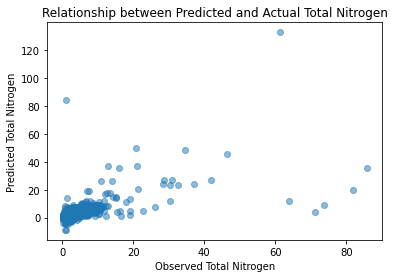

In [49]:
# Plot observed vs predicted delivery week
plt.scatter(y_test, predictions, alpha = 0.5)
plt.xlabel("Observed Total Nitrogen")
plt.ylabel("Predicted Total Nitrogen")
plt.title("Relationship between Predicted and Actual Total Nitrogen")

Text(0.5, 1.0, 'Relationship between $\\hatY$ and the residuals - train')

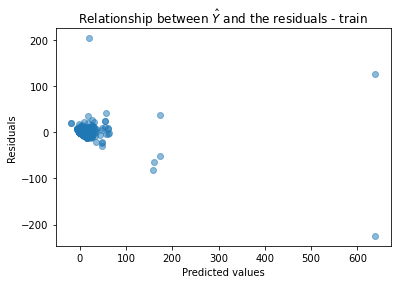

In [52]:
#Distribution of the residuals
plt.scatter(model2.predict(X_train), (y_train - model2.predict(X_train)), alpha = 0.5)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Relationship between $\hatY$ and the residuals - train")

Text(0.5, 1.0, 'Relationship between $\\hatY$ and the residuals - test')

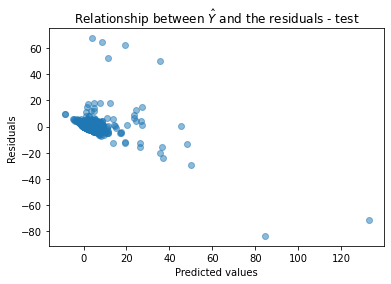

In [53]:
#Distribution of the residuals
plt.scatter(predictions, (y_test - predictions), alpha = 0.5)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Relationship between $\hatY$ and the residuals - test")

In [58]:
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'mg/L')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'mg/L.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
print('MAPE:', round(np.mean(mape), 2), '%.')
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 0.34 mg/L
Standard deviation of absolute error: 1.47 mg/L.
MAPE: 22.09 %.
Accuracy: 77.91 %.


In [60]:
#R^2
R2train = model2.score(X_train, y_train)
print('R2train is :', round(R2train, 4))
R2test = model2.score(X_test, y_test)
print('R2test is :', round(R2test, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

R2train is : 0.8525
R2test is : 0.4757
Adjusted R2 is : 0.8524


In [ ]:
res = model2.calc_feature_statistics(X_train,
                                    y_train,
                                    feature=36,
                                    plot=True)

Once tuned, the results are promising. To further improve the model we could train only the features cumulating to 95% of importance.

In [62]:
model2.get_feature_importance(prettified=True)

,Feature Id,Importances
0,of_dist,28.841586
1,week,7.504957
2,lc_71,7.456781
3,HUC12_,6.757816
4,lc_43,5.586995
5,precip3_narr,5.463123
6,precip48_narr,3.697067
7,lc_42,3.601505
8,lc_22,2.970464
9,year,2.841661


In [64]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index, 
                                      model2.get_feature_importance(Pool(X, label=y, 
                                                                        cat_features=cat_features)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', 
                                          na_position='last')

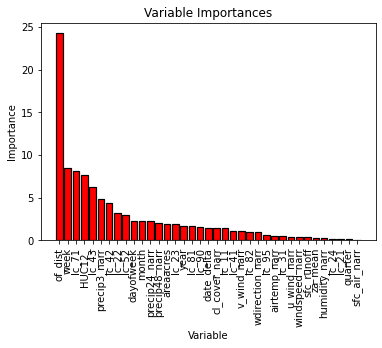

In [65]:
# list of x locations for plotting
x_values = list(range(len(feature_score)))
# Make a bar chart
plt.bar(x_values, feature_score['Score'], orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_score['Feature'], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

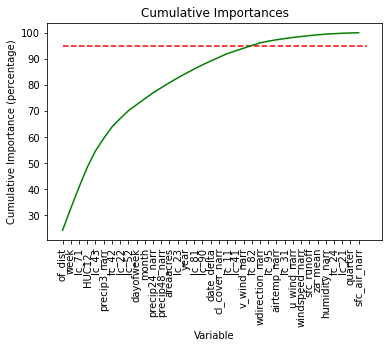

In [66]:
# Cumulative importances
cumulative_importances = np.cumsum(feature_score['Score'])
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 95, xmin=0, xmax=len(feature_score['Score']), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, feature_score['Feature'], rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance (percentage)'); plt.title('Cumulative Importances');

In [67]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
threshold= np.where(cumulative_importances > 95)[0][0] + 1
print('Number of features for 95% importance:', np.where(cumulative_importances > 95)[0][0] + 1)

Number of features for 95% importance: 24


In [68]:
# List of features for later use
feature_list = list(X.columns)
# Extract the names of the most important features
important_feature_names = feature_score[0:threshold]['Feature']
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]
# Create training and testing sets with only the important features
important_X = X.iloc[:, important_indices]
# Sanity check on operations
print('Important features X shape:', important_X.shape)

Important features X shape: (67040, 24)


In [69]:
num_cols = important_X._get_numeric_data().columns
cols = important_X.columns
important_cat_features = list(set(cols) - set(num_cols))
important_cat_features

['month', 'week', 'HUC12_', 'dayofweek', 'year']

In [70]:
cat_features = [important_X.columns.get_loc(i) for i in important_cat_features]
cat_features

[10, 1, 3, 9, 15]

In [71]:
important_X_train, important_X_test, y_train, y_test = train_test_split(important_X, y, test_size = 0.3, random_state= 2)

In [72]:
train_pool2 = Pool(important_X_train, 
                  y_train, 
                  cat_features=cat_features)

In [89]:
param_grid = {'learning_rate': [0.05, 0.1],
              'depth': [6, 10],
              'l2_leaf_reg': [5, 9],
              'bagging_temperature': [0, 0.5],
              'one_hot_max_size': [12, 25],
              'random_strength': [1, 20]}
model3 = CatBoostRegressor(
    iterations = 2500,
    loss_function = 'RMSE',
    verbose = 20,
    task_type = 'GPU')

In [ ]:
grid_search_result = model3.grid_search(param_grid,
            train_pool2,
            cv=3,
            partition_random_seed=2,
            calc_cv_statistics=True,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=False,
            train_size=0.8,
            verbose=True,
            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 1.1496477	best: 1.1496477 (0)	total: 1m 14s	remaining: 1h 18m 31s
1:	loss: 1.2271754	best: 1.1496477 (0)	total: 2m 24s	remaining: 1h 14m 49s
2:	loss: 1.2498403	best: 1.1496477 (0)	total: 3m 39s	remaining: 1h 14m 21s
3:	loss: 1.1524315	best: 1.1496477 (0)	total: 4m 47s	remaining: 1h 11m 55s
4:	loss: 1.1276878	best: 1.1276878 (4)	total: 6m 6s	remaining: 1h 12m
5:	loss: 1.2041599	best: 1.1276878 (4)	total: 7m 16s	remaining: 1h 10m 16s
6:	loss: 1.0867078	best: 1.0867078 (6)	total: 8m 34s	remaining: 1h 9m 48s
7:	loss: 1.0740280	best: 1.0740280 (7)	total: 9m 44s	remaining: 1h 8m 11s
8:	loss: 0.9690084	best: 0.9690084 (8)	total: 11m	remaining: 1h 7m 18s
9:	loss: 0.9982773	best: 0.9690084 (8)	total: 12m 9s	remaining: 1h 5m 37s
10:	loss: 1.0293037	best: 0.9690084 (8)	total: 13m 27s	remaining: 1h 4m 49s
11:	loss: 0.9818432	best: 0.9690084 (8)	total: 14m 38s	remaining: 1h 3m 27s
12:	loss: 0.9914550	best: 0.9690084 (8)	total: 15m 55s	remaining: 1h 2m 28s
13:	loss: 0.9541046	best: 0.954104

In [85]:
grid_search_result

{'params': {'random_strength': 1,
  'one_hot_max_size': 25,
  'l2_leaf_reg': 9,
  'bagging_temperature': 0.5,
  'learning_rate': 0.05},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
          

In [ ]:
model4 = CatBoostRegressor(
    iterations = 2000,
    learning_rate = 0.1,
    random_strength = 10,
    one_hot_max_size= 14,
    depth = 10,
    l2_leaf_reg= 1,
    bagging_temperature= 1.0,
    loss_function = 'RMSE',
    verbose = 20,
    task_type = 'GPU')

In [ ]:
important_X_train, important_X_test, y_train, y_test = train_test_split(important_X, y, test_size = 0.3, random_state= 2)

In [ ]:
model4.fit(important_X_train, y = y_train, cat_features=cat_features,
          eval_set = (important_X_test, y_test), plot=True, verbose= 50)

In [86]:
predictions = model3.predict(important_X_test)

In [87]:
# Performance metrics
errors = abs(round(predictions - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'mg/L')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'mg/L.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
print('MAPE:', round(np.mean(mape), 2), '%.')
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 0.33 mg/L
Standard deviation of absolute error: 1.5 mg/L.
MAPE: 18.85 %.
Accuracy: 81.15 %.


In [88]:
#R^2
R2train = model3.score(important_X_train, y_train)
print('R2train is :', round(R2train, 4))
R2test = model3.score(important_X_test, y_test)
print('R2test is :', round(R2test, 4))
n = X_train.shape[0]
p = X_train.shape[1]
adj_R2 = 1-(1-R2train)*(n-1)/(n-p-1)
print('Adjusted R2 is :', round(adj_R2, 4))

R2train is : 0.8727
R2test is : 0.4607
Adjusted R2 is : 0.8726


Limiting to features to 95% of importance improved the model accuracy, MAPE and R2. 